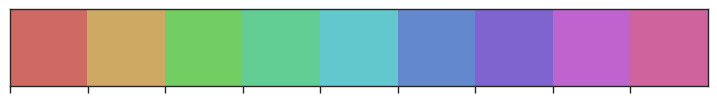

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 100

In [2]:
a = 2
b = 5.5
c = 1
d = 1

@numba.njit
def x_dot(x, y, V):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot(x, y, V):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt
    
@numba.njit
def x_mark(V, a, d):
    return a*V / d

@numba.njit
def y_mark(V, a, b,  c, d):
    return V * b * d / (c * a)


In [3]:
# Euler method

@numba.njit
def euler(var_change, V, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, V)
        y += dt * y_dot(x, y, V)
        t += dt
    return x_list, y_list, t_list


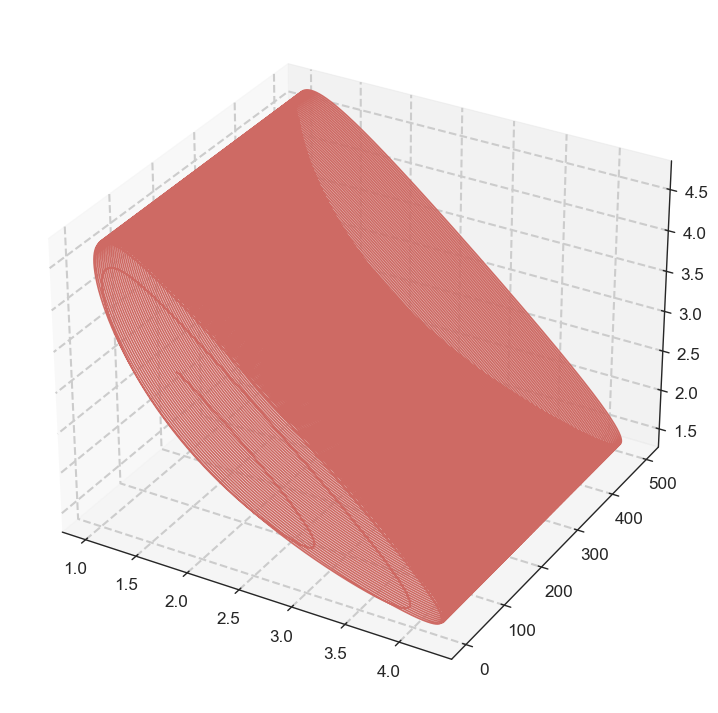

In [4]:

V = 1
var_change = np.array([1.8, 3.5])
dt = 0.001
t_max = 500

x_list, y_list, t_list = euler(var_change, V, dt, t_max)
x_star = x_mark(V, a, d)
y_star = y_mark(V, a, b, c, d)

# 3D plot
fig = plt.figure(figsize=(16,9), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, t_list, y_list)


In [5]:
# Finding peaks and mean freq of x(t) and y(t)

def freq_find(list1, list2):
    coord_peaks = []
    t_peaks = []
    for i in range(1, len(list1)-1):
        if list1[i] > list1[i-1] and list1[i] > list1[i+1]:
            coord_peaks.append(list1[i])
            t_peaks.append(list2[i])

    freq = []
    for j in range(len(t_peaks)-1):
        freq.append(1/(t_peaks[j+1] - t_peaks[j]))
    
    freq_mean = np.mean(freq)
    
    return freq_mean

# find the frequency of the peaks

x_mean_freq = freq_find(x_list, t_list)
y_mean_freq = freq_find(y_list, t_list)



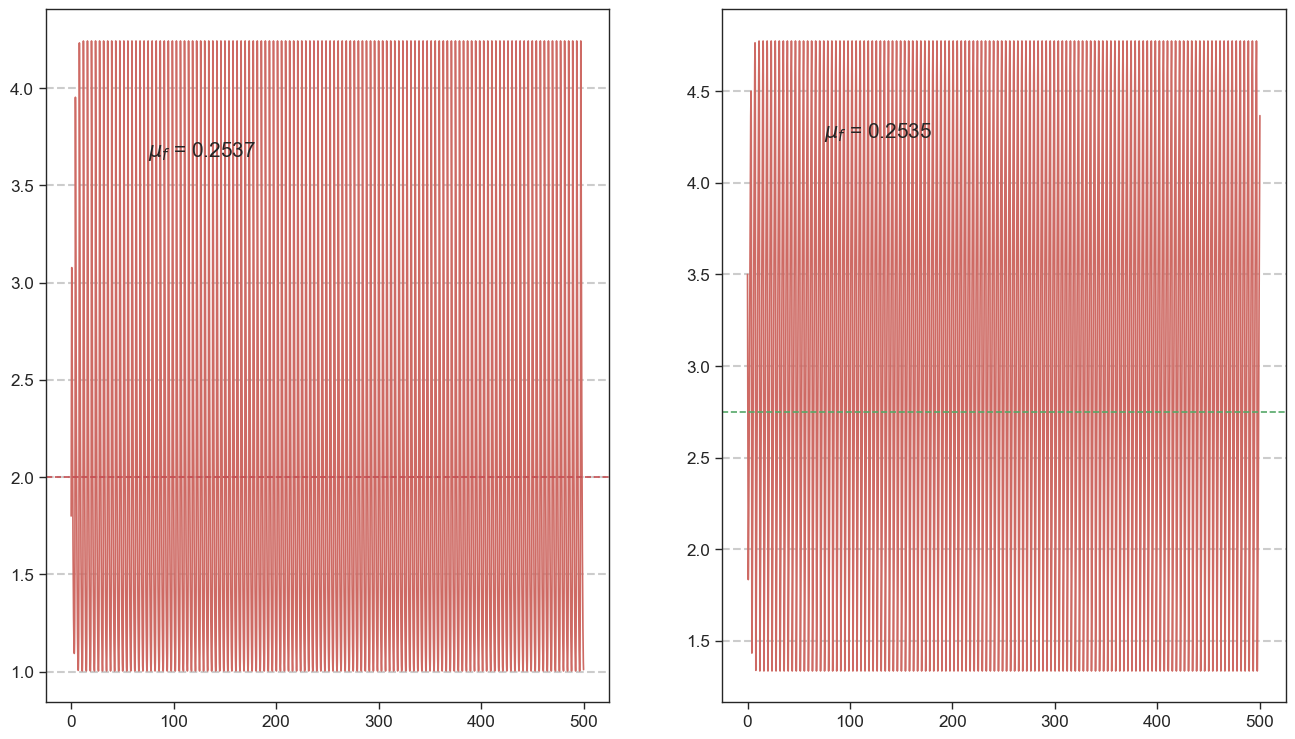

In [6]:

fig, ax = plt.subplots(1,2, figsize=(16,9), dpi=100)
ax[0].plot(t_list, x_list, label='x')
# ax[0].plot(tx_peaks, x_peaks, 'ro', label='peaks')
ax[0].axhline(x_star, color='r', linestyle='--', label='x*')
ax[0].text(75, 3.65, f'$\mu_f$ = {x_mean_freq:.4f}', fontsize=15);

ax[1].plot(t_list, y_list, label='y')
# ax[1].plot(ty_peaks, y_peaks, 'ro', label='peaks')
ax[1].axhline(y_star, color='g', linestyle='--', label='y*')

ax[1].text(75, 4.25, f'$\mu_f$ = {y_mean_freq:.4f}', fontsize=15);

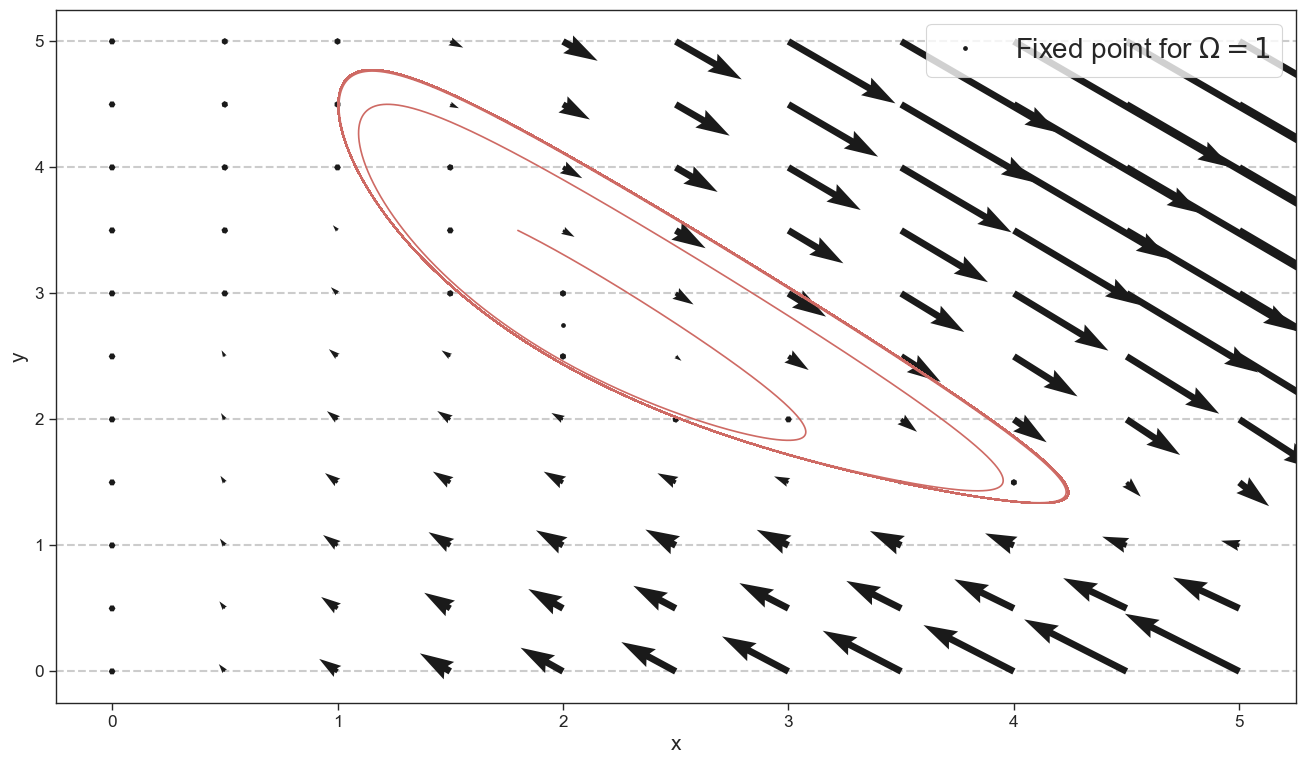

In [7]:
# 2D plot
fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(x_list, y_list)
plt.plot(x_star, y_star, 'k.', label=f'Fixed point for $\Omega = {V}$')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)


# Vector field
field_size = np.arange(0, 5.5, 0.5)
X, Y = np.meshgrid(field_size, field_size)
U = x_dot(X, Y, V)
P = y_dot(X, Y, V)


plt.quiver(X, Y, U, P, angles='xy');


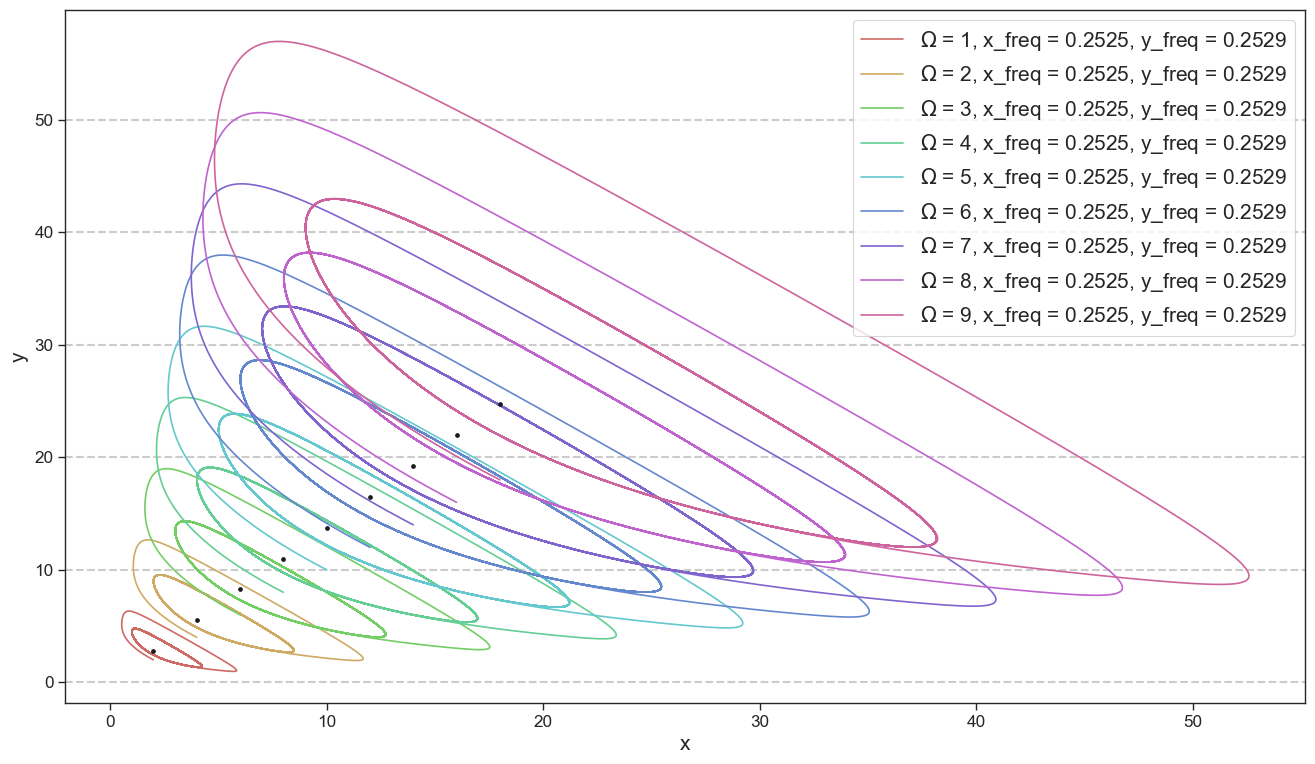

In [8]:
omega = np.arange(1, 10, 1)
var_change = np.array([2, 2])
x_mark_list = []
y_mark_list = []
x_freq_list = []
y_freq_list = []
dt_new = 0.001
t_max_new = 100

plt.figure(figsize=(16,9), dpi=100)
for i in omega:
    x_list_sim, y_list_sim, t_list_sim = euler(var_change, i, dt_new, t_max_new)
    x_mark_list.append(x_mark(i, a, d))
    y_mark_list.append(y_mark(i, a, b, c, d))
    x_freq = freq_find(x_list_sim, t_list_sim)
    y_freq = freq_find(y_list_sim, t_list_sim)
    plt.plot(x_list_sim, y_list_sim, label=f'$\Omega$ = {i}, x_freq = {x_freq:.4f}, y_freq = {y_freq:.4f}')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=15)

plt.plot(x_mark_list, y_mark_list, 'k.', label='Stable fixed point')

____

# Adding oscillatory term $ A cos(\omega t)$

In [9]:

@numba.njit
def x_dot(x, y, t, a, b, c, d, V, omega, A):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y + A * np.cos(omega * t)
    return dxdt

@numba.njit
def y_dot(x, y, V, b, c):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt

a = 2
b = 4.5
c = 1
d = 1
V = 100

@numba.njit
def euler(var_change, V, omega, A, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, t, a, b, c, d, V, omega, A)
        y += dt * y_dot(x, y, V, b, c)
        t += dt
    return x_list, y_list, t_list

@numba.njit
def amplitude_find(list1, list2, t_list, t_choise = 30):
    t_list = np.array(t_list)
    list1 = np.array(list1)
    list2 = np.array(list2)
    
    mask = np.where(t_list > t_choise)
    list1_mask = list1[mask[0]]
    list2_mask = list2[mask[0]]

    return np.max(list1_mask) - np.min(list1_mask), np.max(list2_mask) - np.min(list2_mask)



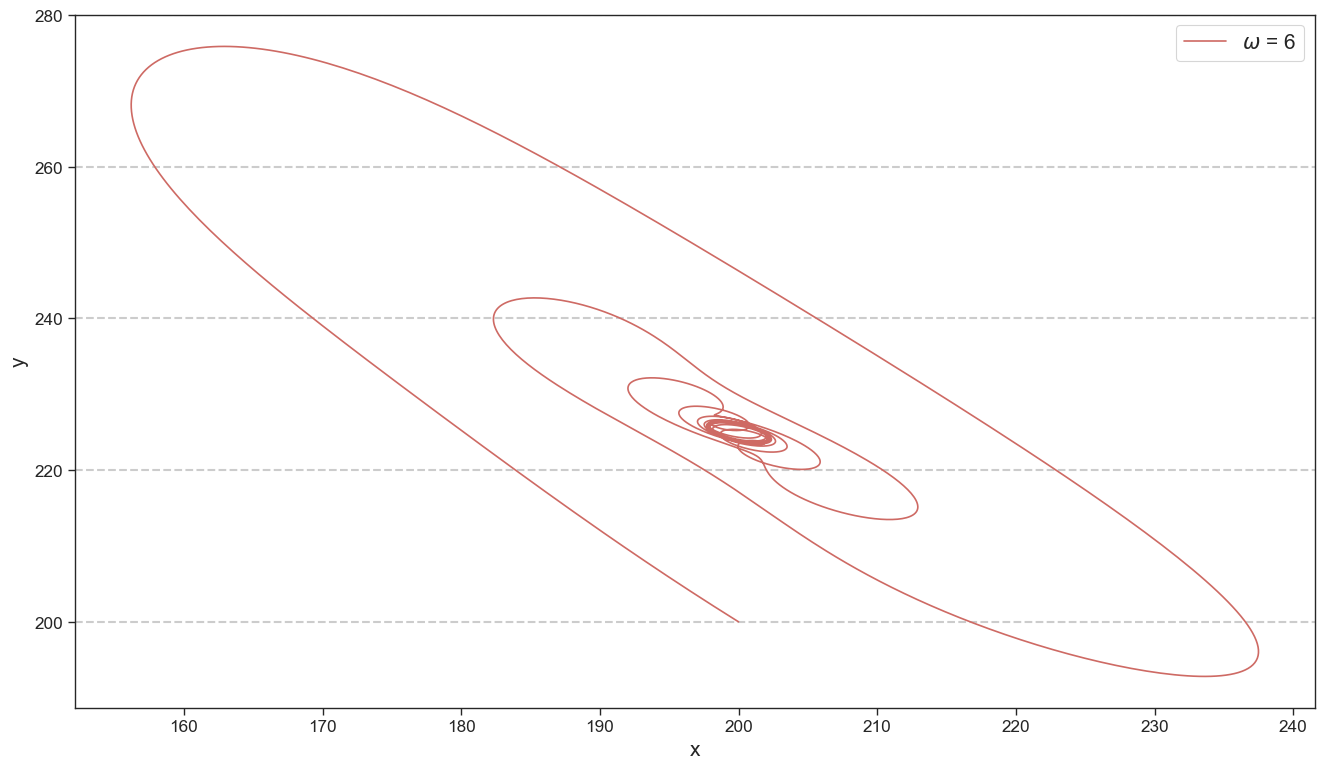

In [10]:
# run euler simulaiton with new x_dot and y_dot functions

omega = np.array([6])
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig, ax = plt.subplots(figsize=(16,9), dpi=100)

for i in omega:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    ax.plot(x_list, y_list, label=f'$\omega$ = {i}')

ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.legend(fontsize=15)




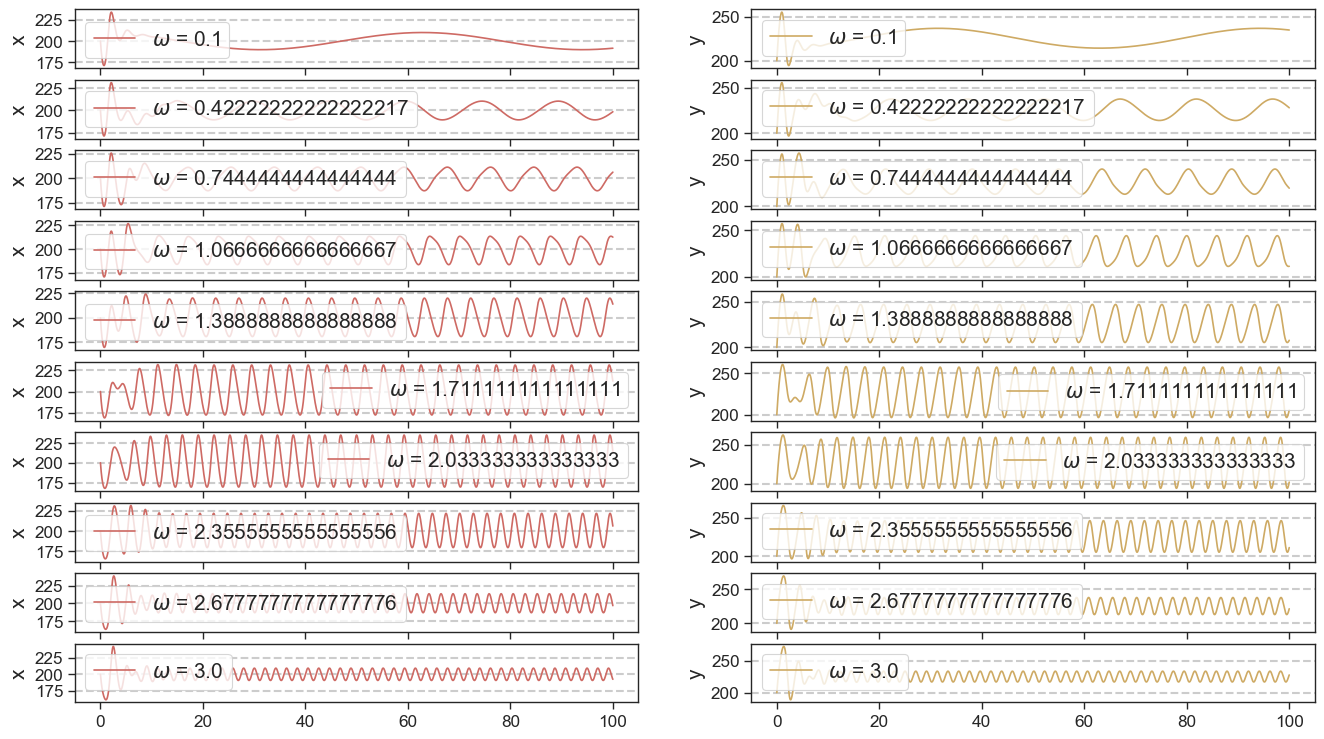

In [11]:
# plot x(t) and y(t) for different omega values

omega = np.linspace(0.1, 3, 10)
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig_rows = len(omega)
fig, ax = plt.subplots(fig_rows, 2, figsize=(16,9), dpi=100)


amp_x = []
amp_y = []

for i, j in enumerate(omega):
    x_list, y_list, t_list = euler(var_change, V, j, A, dt, t_max)
    

    ax[i, 0].plot(t_list, x_list, label=f'$\omega$ = {j}')
    ax[i, 1].plot(t_list, y_list, label=f'$\omega$ = {j}', color = colors[1])
    ax[i, 0].set_ylabel('x', fontsize=15)
    ax[i, 1].set_ylabel('y', fontsize=15)
    ax[i, 0].legend(fontsize=15)
    ax[i, 1].legend(fontsize=15)



### For a large number of $\omega$ 

In [12]:
omega_list = np.linspace(0.1, 5, 100)    
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

amp_x = []
amp_y = []

for i in omega_list:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    x_max, y_max = amplitude_find(x_list, y_list, t_list, t_choise=30)
    amp_x.append(x_max)
    amp_y.append(y_max)


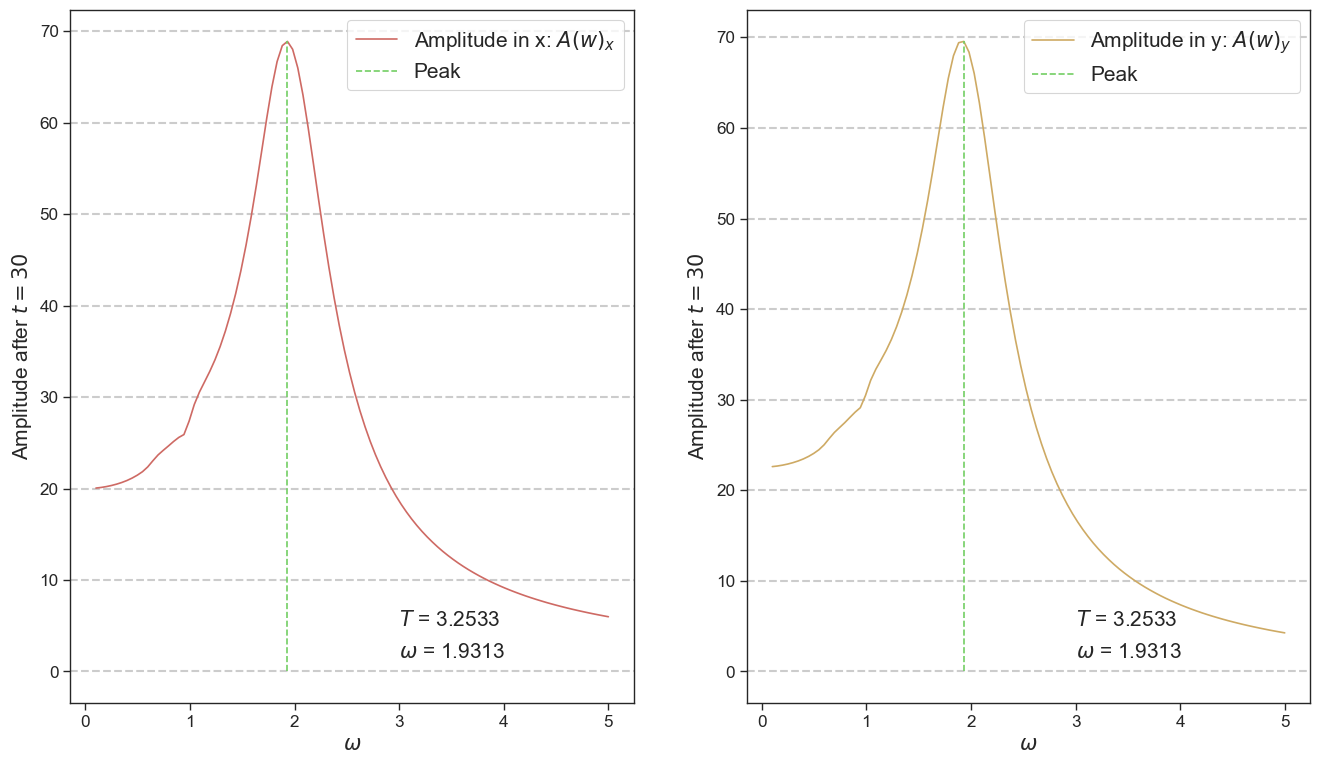

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,9), dpi=100)
ax = ax.flatten()

# find peak

x_peak = np.max(amp_x)
y_peak = np.max(amp_y)
omega_x_peak = omega_list[np.argmax(amp_x)]
omega_y_peak = omega_list[np.argmax(amp_y)]
T_x = 2*np.pi/omega_x_peak
T_y = 2*np.pi/omega_y_peak

ax[0].plot(omega_list, amp_x, label=r'Amplitude in x: $A(w)_x$')
ax[0].set_xlabel('$\omega$', fontsize=15)
ax[0].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[0].vlines(omega_x_peak, 0, x_peak, color= colors[2], linestyle='--', label='Peak')
ax[0].text(3, 1.5, fr'$\omega$ = {omega_x_peak:.4f}', fontsize=15);
ax[0].text(3, 5, f'$T$ = {T_x:.4f}', fontsize=15);
ax[0].legend(fontsize=15)

ax[1].plot(omega_list, amp_y, label=r'Amplitude in y: $A(w)_y$', color = colors[1])
ax[1].set_xlabel('$\omega$', fontsize=15)
ax[1].vlines(omega_y_peak, 0, y_peak, color=colors[2], linestyle='--', label='Peak')
ax[1].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[1].text(3, 1.5, fr'$\omega$ = {omega_y_peak:.4f}', fontsize=15);
ax[1].text(3, 5, f'$T$ = {T_y:.4f}', fontsize=15);
ax[1].legend(fontsize=15)


____

# Gillespie algorithm

In [14]:
@numba.njit(fastmath=True)
def gillespie(x, y, t_max, b_place=b, V=100):

    t = 0
    click = 1
    t_list = [0]
    x_list = [x]
    y_list = [y]

    a = 2 * V
    c = 1/V**2
    d = 1
    
    
    while t < t_max:
        # rates
        x_spawn = a
        x_to_y = b_place * x
        y_to_x = c * x * (x-1) * y
        x_despawn = d * x
        
        rates = np.array([x_spawn, x_to_y, y_to_x, x_despawn])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R


        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x += 1

        elif index == 1:
            x -= 1
            y += 1

        elif index == 2:
            y -= 1
            x += 1

        elif index == 3:
            x -= 1
        
        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x_list.append(x)
            y_list.append(y)
            click += 1

        #t_list.append(t)
        #x_list.append(x)
        #y_list.append(y)

    return np.array(t_list), np.array(x_list), np.array(y_list)



In [15]:
# Gillespie simulation initialization
vol = 100
x = 100
y = 100
t_max = 250

# Setting parameters
a = 2
b = 5.5
c = 1
d = 1

# Running simulation
t_list, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
x_star = x_mark(vol, a, d)
y_star = y_mark(vol, a, b, c, d)


[]


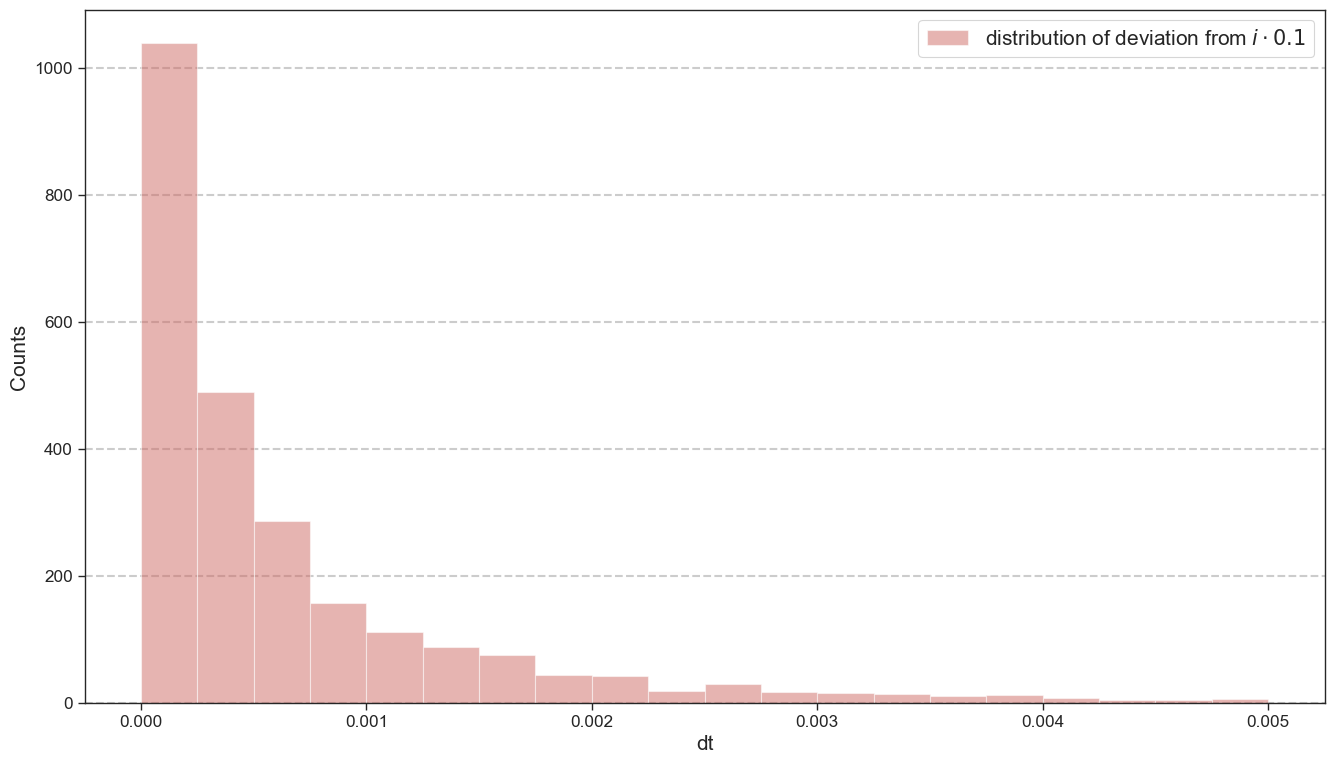

In [16]:
# Checking that the time steps are correct

n = np.arange(0, t_list[-1], 0.1)

dt_list = t_list - n
plt.hist(dt_list, bins=20, range=(0, 0.005), alpha=0.5, label=r'distribution of deviation from $i \cdot 0.1$');
plt.xlabel('dt', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(fontsize=15)

over = np.where(dt_list > 0.1)
print(over[0])

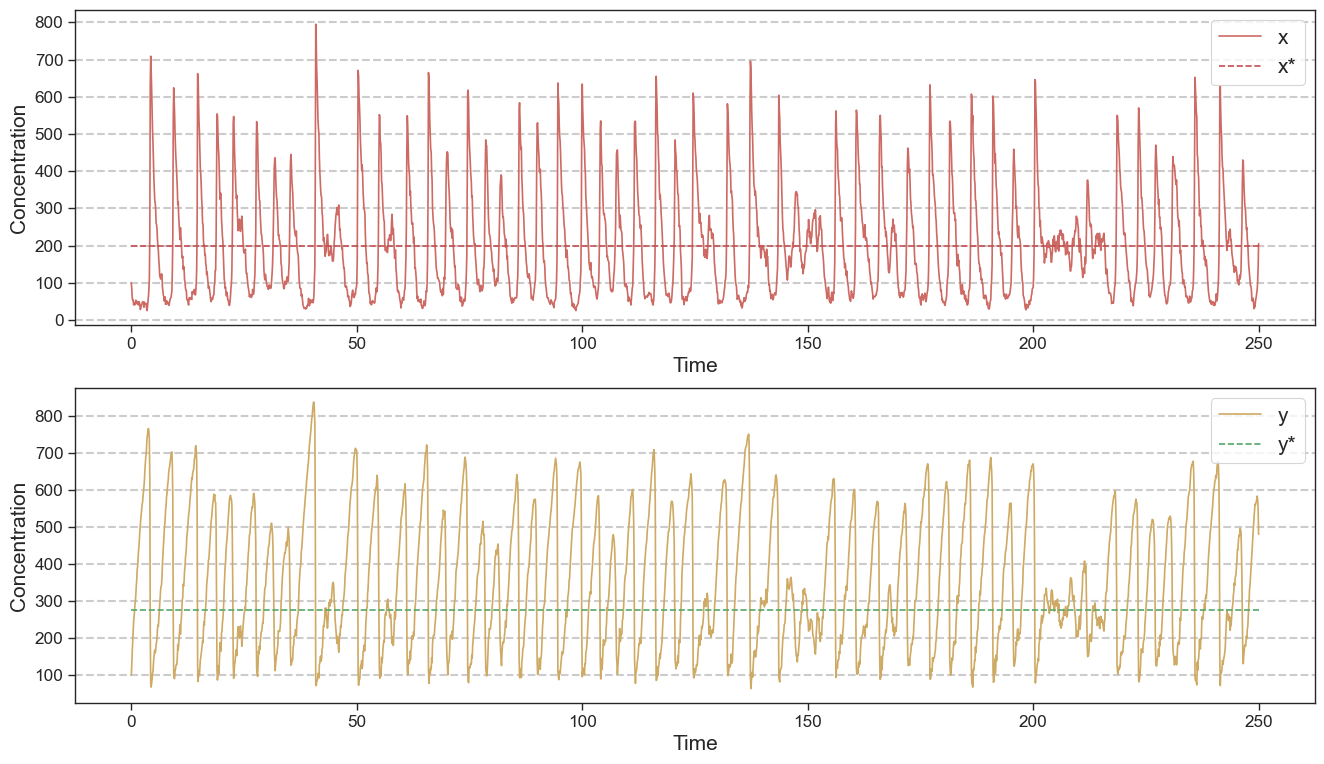

In [17]:
# Plotting gillespie simulation

fig, ax = plt.subplots(2, 1, figsize=(16,9), dpi=100)
ax[0].plot(t_list, x_sim, label='x', color=colors[0])
ax[0].hlines(x_star, 0, t_max, color='r', linestyle='--', label='x*')

ax[1].plot(t_list, y_sim, label='y', color=colors[1])
ax[1].hlines(y_star, 0, t_max, color='g', linestyle='--', label='y*')


for i in range(len(ax)):
    ax[i].set_xlabel('Time', fontsize=15)
    ax[i].set_ylabel('Concentration', fontsize=15)
    ax[i].legend(fontsize=15)



In [18]:

@numba.njit(fastmath=True)
def peak_find(t_list, y_list, neigh=10):
    t_peak = []
    peaks = []
    for i in range(len(y_list) - neigh):
        if y_list[i] > y_list[i-1] and y_list[i] > y_list[i+1]:


            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] > y_list[i-j] and y_list[i] > y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                peaks.append(y_list[i])
                t_peak.append(t_list[i])

    return np.array(t_peak), np.array(peaks),


@numba.njit(fastmath=True)
def valley_find(t_list, y_list, neigh=10):
    t_valley = []
    valleys = []
    for i in range(len(y_list) - neigh):
        if y_list[i] < y_list[i-1] and y_list[i] < y_list[i+1]:


            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] < y_list[i-j] and y_list[i] < y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                valleys.append(y_list[i])
                t_valley.append(t_list[i])

    return np.array(t_valley), np.array(valleys)


@numba.njit(fastmath=True)
def amp_match(t_peak, y_peak, t_valley, y_valley):
    amp = []
    for i in range(len(t_peak) - 1):
        bigr = t_peak[i] < t_valley
        if sum(bigr) > 0:
            match = np.where(bigr == True)[0][0]
            amp.append((y_peak[i] - y_valley[match]))
        else:
            break
    return np.array(amp)


@numba.njit(fastmath=True)
def easy_fourier(t_list, y_list):
    array = np.array([0.1 * i for i in range(len(t_list))])
    dt_ty =  t_list - array
    sr = np.mean(dt_ty) + 0.1
    
    y_fft = np.fft.fft(y_list)
    amplitude_spectrum = np.abs(y_fft)
    frequencies = np.fft.fftfreq(len(y_fft), sr)
    freq_slice = frequencies[1:len(frequencies)//2]
    amp_slice = amplitude_spectrum[1:len(amplitude_spectrum)//2]
    peak_freq = freq_slice[np.argmax(amp_slice)]
    return freq_slice, amp_slice, peak_freq


In [19]:
### High pass filter

# Define the cutoff frequency (in Hz)
cutoff_frequency = 0.04  # Cutoff frequency for high-pass filter
sampling_rate = np.mean(dt_list+0.1)

# Design the filter
nyquist = 0.5 * sampling_rate  # Nyquist frequency
normal_cutoff = cutoff_frequency / nyquist  # Normalize the cutoff frequency

b, a = signal.butter(4, normal_cutoff, btype='high', analog=False)  # 4th order Butterworth filter



In [20]:
# Making a Fourier spectrum of x(t) and y(t) using FFT
x_fft = np.fft.fft(x_sim)
y_fft = np.fft.fft(y_sim)


##### Aply HP filter #####
x_hpf = x_fft #signal.filtfilt(b, a, x_fft)
y_hpf = y_fft #signal.filtfilt(b, a, y_fft)
##########################

# sr = np.mean(dt_list+0.1)
# amplitude_spectrum = np.abs(y_hpf)
# frequencies = np.fft.fftfreq(len(y_hpf), sr)
# freq_slice = frequencies[1:len(frequencies)//2]
# amp_slice = amplitude_spectrum[1:len(amplitude_spectrum)//2]
# peak_freq = freq_slice[np.argmax(amp_slice)]
mean_y = np.mean(y_sim)
y_norm = y_sim - mean_y
freq, amp, peak_freq = easy_fourier(t_list, y_norm)

# Plot the amplitude spectrum

fig, ax = plt.subplots(2,1, dpi=100)
ax[0].plot(freq, amp, marker='.', ls='-')
ax[0].text(1.5, 10000, f'Peak frequency = {peak_freq:.4f}', fontsize=15)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')
ax[0].legend() 


y_reversed = np.fft.ifft(y_hpf)
# Plot reversed signal
ax[1].plot(t_list, y_reversed, label='Reversed signal', color=colors[1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')
ax[1].legend()

KeyboardInterrupt: 

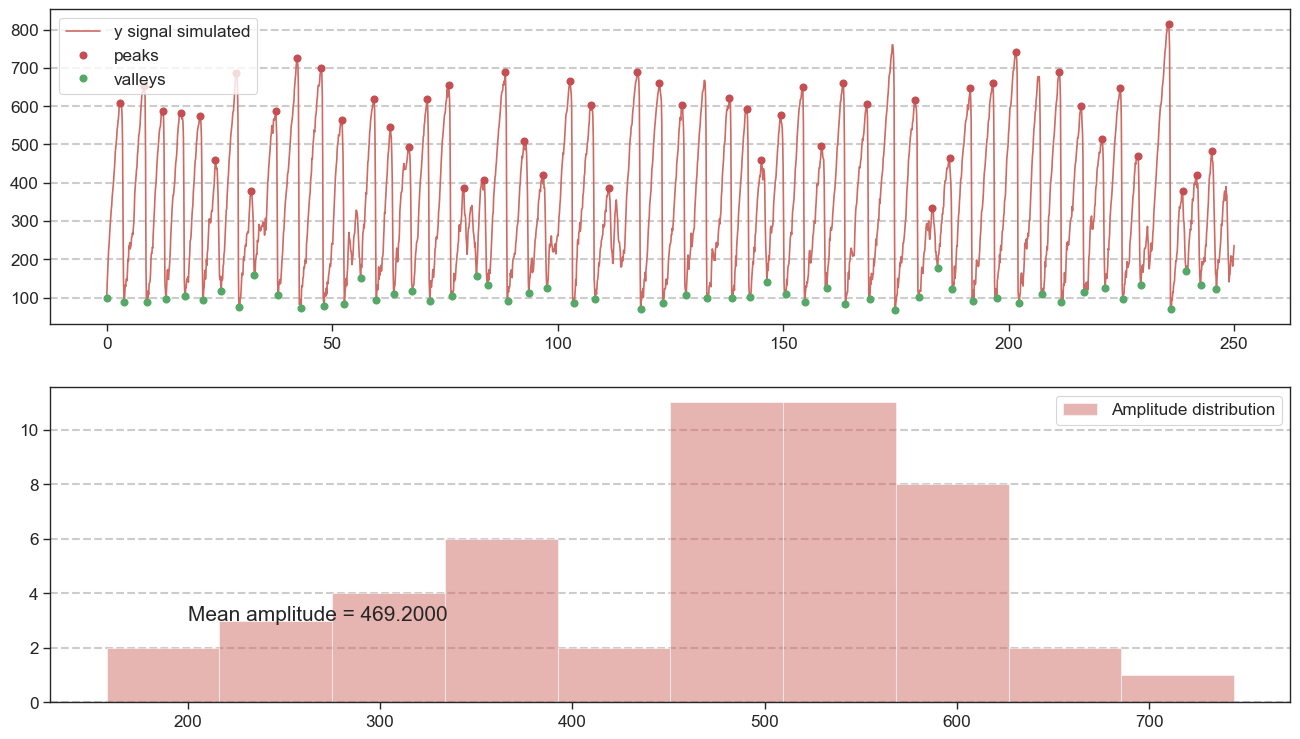

In [ ]:
t_peaks, y_peaks = peak_find(t_list, y_sim, neigh=20)
t_valleys, y_valleys= valley_find(t_list, y_sim, neigh=20)

# Match peaks with valleys
amp = amp_match(t_peaks, y_peaks, t_valleys, y_valleys)
mean_amp = np.mean(amp)


fig, ax = plt.subplots(2, 1, dpi=100)
ax[0].plot(t_list, y_sim, label='y signal simulated')
ax[0].plot(t_peaks, y_peaks, 'ro', label='peaks')
ax[0].plot(t_valleys, y_valleys, 'go', label='valleys')
ax[0].legend()
ax[1].hist(amp, bins=10, alpha=0.5, label='Amplitude distribution');
ax[1].text(200, 3, f'Mean amplitude = {mean_amp:.4f}', fontsize=15)
ax[1].legend()



In [ ]:
# Defining Gillespie simulation function

@numba.njit(fastmath=True)
def gil_sim(b, vol, t_max, x, y):
    t_sim, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
    f_slice, a_slice, peak_f = easy_fourier(t_sim, y_sim)
    t_peak, y_peak = peak_find(t_sim, y_sim, neigh=20)
    t_valley, y_valley = valley_find(t_sim, y_sim, neigh=20)

    amps = amp_match(t_peak, y_peak, t_valley, y_valley)
    mean_amp = np.mean(amps)

    return peak_f, amps, mean_amp
    

In [ ]:
# Initializing gillespie simulation
vol = 100
x = 100
y = 100
b_val = np.array([4.5, 5.5])
t_max = 250
N = 1000

# Running simulation
b_amp_mean = []
for i in b_val:
    mean_amp_list = []
    for j in range(N):
        peak_f, amps, mean_amp = gil_sim(i, vol, t_max, x, y)
        mean_amp_list.append(mean_amp/vol)
    
    b_amp_mean.append(mean_amp_list)


Text(0.5, 0.98, 'Mean amplitude distribution for different b values for vol = 100')

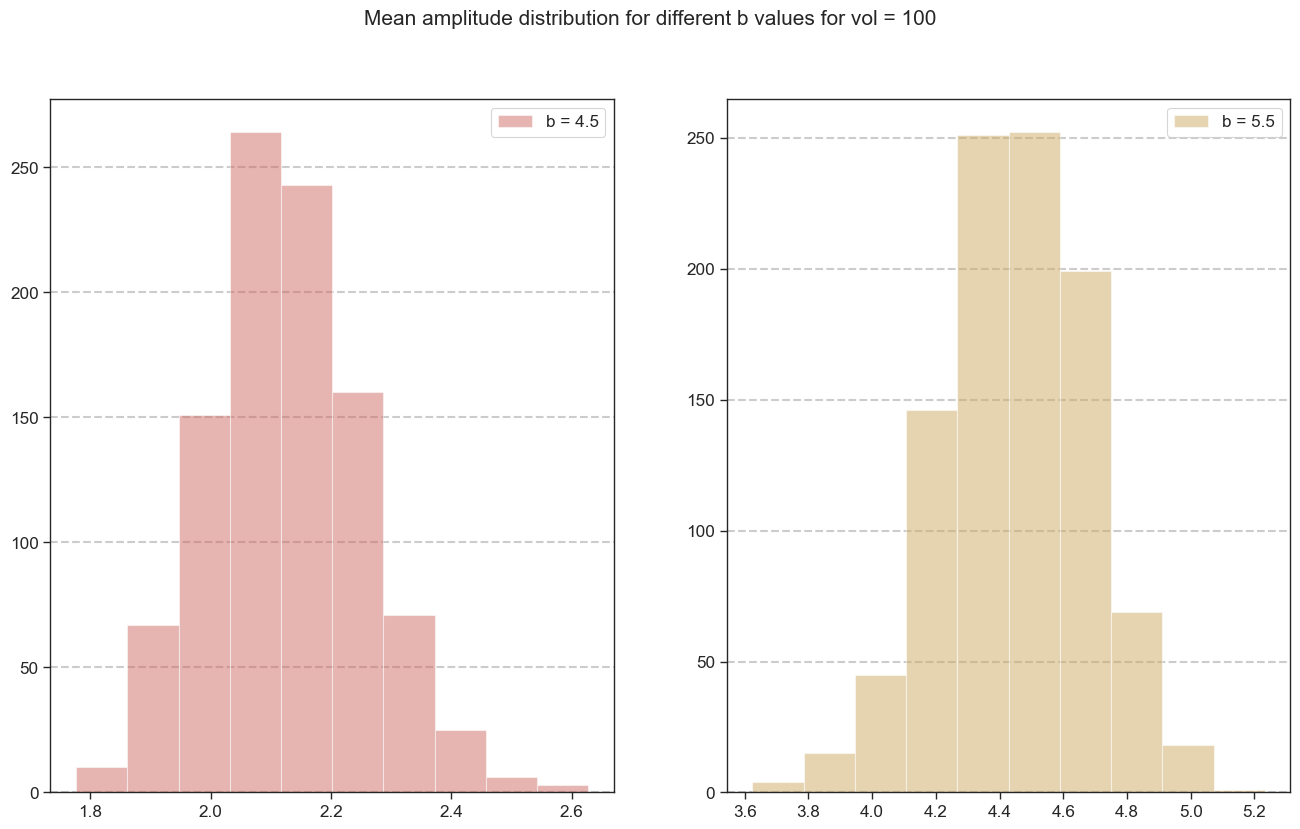

In [ ]:
# Results 

#sigma_amp = np.std(mean_amp_list)
#print(f'Standard deviation of mean amplitudes sigma_A = {sigma_amp:.2f}')
b_amp_mean = np.array(b_amp_mean)

N_bins = 10

fig, ax = plt.subplots(1, 2)
ax[0].hist(b_amp_mean[0], bins=N_bins, alpha=0.5, label='b = 4.5', color=colors[0])
ax[0].legend()
ax[1].hist(b_amp_mean[1], bins=N_bins, alpha=0.5, label='b = 5.5', color=colors[1])
ax[1].legend()
fig.suptitle('Mean amplitude distribution for different b values for vol = 100', fontsize=15)

### Running the Gillespie algorithm for different volumes $\Omega$

In [ ]:
a = 2
c = 1
d = 1
b = [4.5, 5.5]

x = 100
y = 100

vol = np.linspace(20, 240, 12)

t_max = 250
N = 100

print(vol)

[ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240.]


In [ ]:
from tqdm import tqdm

In [ ]:
vol_amp = []
sigma_list = []
for i in tqdm(vol):
    b_amp_list = []
    b_sigma_list = []
    for j in b:
        mean_amp_list = []
        for _ in range(N):
            peak_f, amps, mean_amp = gil_sim(j, i, t_max, x, y)

            mean_amp_list.append(mean_amp)
        b_sigma_list.append(np.std(mean_amp_list/i))
        b_amp_list.append(mean_amp_list/i)
    sigma_list.append(b_sigma_list)
    vol_amp.append(b_amp_list)

100%|██████████| 12/12 [1:03:50<00:00, 319.22s/it]


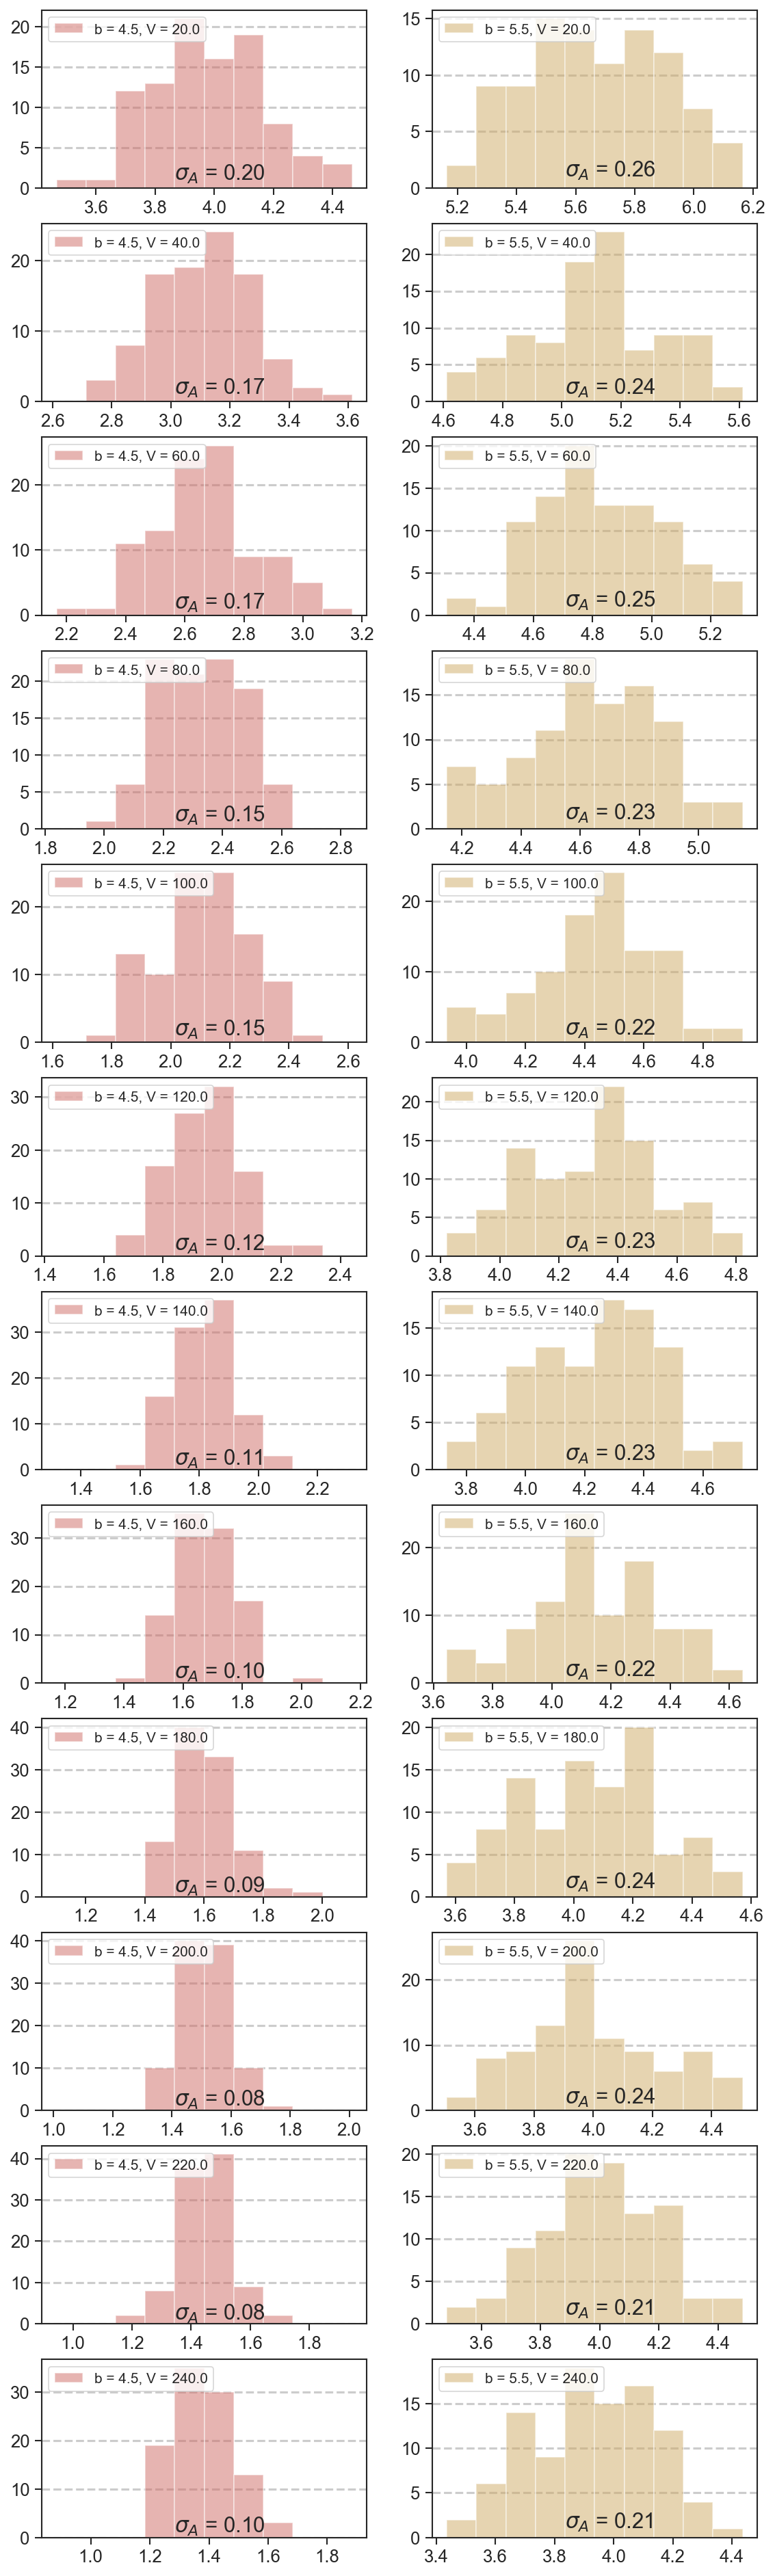

In [ ]:
fig, ax = plt.subplots(len(vol), 2, figsize=(9, 32), dpi=150)
N_bins = 10

for i in range(len(vol)):
    for j in range(2):
        mean_dist = np.mean(vol_amp[i][j])
        r_low = mean_dist - 0.5
        r_high = mean_dist + 0.5
        hist_range = [r_low, r_high]
        ax[i, j].hist(vol_amp[i][j], range = hist_range, bins=N_bins, alpha=0.5, label=f'b = {b[j]}, V = {vol[i]}', color=colors[j])
        ax[i, j].text(mean_dist - 0.1, 1, f'$\sigma_A$ = {sigma_list[i][j]:.2f}', fontsize=15)
        ax[i, j].legend(fontsize=10, loc='upper left')
    
        # ax[i, j].set_title(f'Volume = {vol[i]}')


In [ ]:
# Plotting the mean amplitude as a function of volume

mean_amp_b45 = []
std_b45 = []

mean_amp_b55 = []
std_b55 = []

for i in vol_amp:
    mean_amp_b45.append(np.mean(i[0]))
    std_b45.append(np.std(i[0]))

    mean_amp_b55.append(np.mean(i[1]))
    std_b55.append(np.std(i[1]))

fig, ax = plt.subplots(2,1)
ax[0].plot(vol, mean_amp_b45, label=r'$\frac{A(\Omega )}{\Omega}, b = 4.5$', color=colors[0], marker='o', ls='')
ax[0].plot(vol, mean_amp_b55, label=r'$\frac{A(\Omega )}{\Omega}, b = 5.5$', color=colors[3], marker='o', ls='')
ax[0].set_xlabel(r'$\Omega$', fontsize=15)
ax[0].set_ylabel(r'$A(\Omega)$', fontsize=15)
ax[0].legend(fontsize=15)

ax[1].plot(vol, std_b45, label=r'$\sigma_A (\Omega), b = 4.5$', color=colors[0], marker='o', ls='')
ax[1].plot(vol, std_b55, label=r'$\sigma_A (\Omega), b = 5.5$', color=colors[3], marker='o', ls='')
ax[1].set_xlabel(r'\Omega', fontsize=15)
ax[1].set_ylabel(r'\sigma_A (\Omega)', fontsize=15)
ax[1].legend(fontsize=15)



NameError: name 'vol_amp' is not defined

____

## System with $\Omega = \Omega_1 + \Omega_2$

In [ ]:
# Defining gillespie algorithm for system with V = v1 + v2

@numba.njit(fastmath=True)
def gill_vnew(x1, y1, x2, y2, v1, v2, t_max, b_place):
    
    t = 0
    click = 1
    t_list = [0]

    x1_list = [x1]
    y1_list = [y1]

    x2_list = [x2]
    y2_list = [y2]

    v1_list = [v1]
    v2_list = [v2]

    while t < t_max:

        v1 = (x1+y1)/(x1+y1+x2+y2) * (v1 + v2)
        v2 = (x2+y2)/(x1+y1+x2+y2) * (v1 + v2)

        a1 = 2 * v1
        c1 = 1/ v1**2
        d1 = 1

        a2 = 2 * v2
        c2 = 1/ v2**2
        d2 = 1

        # rates for v1
        x1_s = a1
        x1_to_y1 = b_place * x1
        y1_to_x1 = c1 * x1 * (x1-1) * y1
        x1_ds = d1 * x1

        # rates for v2
        x2_s = a2
        x2_to_y2 = b_place * x2
        y2_to_x2 = c2 * x2 * (x2-1) * y2
        x2_ds = d2 * x2

        rates = np.array([x1_s, x1_to_y1, y1_to_x1, x1_ds, x2_s, x2_to_y2, y2_to_x2, x2_ds])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R

        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x1 += 1

        elif index == 1:
            x1 -= 1
            y1 += 1

        elif index == 2:
            y1 -= 1
            x1 += 1

        elif index == 3:
            x1 -= 1

        elif index == 4:
            x2 += 1

        elif index == 5:
            x2 -= 1
            y2 += 1
        
        elif index == 6:
            y2 -= 1
            x2 += 1

        elif index == 7:
            x2 -= 1

        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x1_list.append(x1)
            y1_list.append(y1)
            x2_list.append(x2)
            y2_list.append(y2)
            v1_list.append(v1)
            v2_list.append(v2)
            
            click += 1
        
    return np.array(t_list), np.array(x1_list), np.array(y1_list), np.array(x2_list), np.array(y2_list), np.array(v1_list), np.array(v2_list)

    

In [ ]:
# Gillespie simulation initialization

# Starting parameters [x, y, v]
start1 = [100, 100, 100]
start2 = [100, 100, 100]

t_max = 250
b = 4.5

# Running simulation
t_list, x1_sim, y1_sim, x2_sim, y2_sim, v1_list, v2_list = gill_vnew(start1[0], start1[1], start2[0], start2[1], start1[2], start2[2], t_max, b)



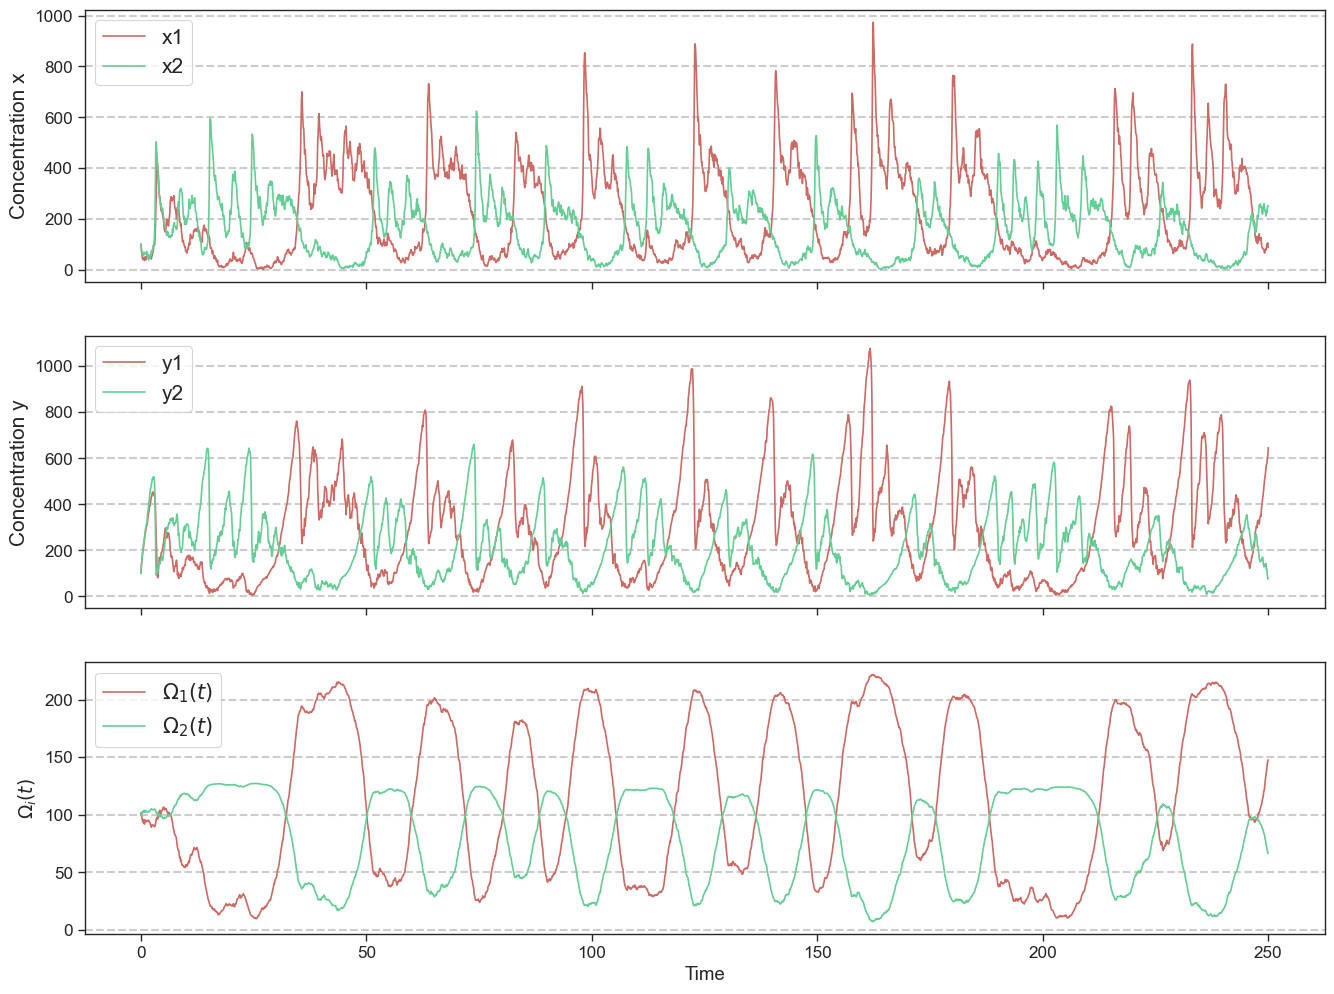

In [ ]:
# Plotting results

fig, ax = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
ax[0].plot(t_list, x1_sim, label='x1', color=colors[0])
ax[0].plot(t_list, x2_sim, label='x2', color=colors[3])
ax[0].set_ylabel('Concentration x', fontsize=15)

ax[1].plot(t_list, y1_sim, label='y1', color=colors[0])
ax[1].plot(t_list, y2_sim, label='y2', color=colors[3])
ax[1].set_ylabel('Concentration y', fontsize=15)

ax[2].plot(t_list, v1_list, label = r'$\Omega_1(t)$', color=colors[0])
ax[2].plot(t_list, v2_list, label = r'$\Omega_2(t)$', color=colors[3])
ax[2].set(xlabel='Time', ylabel=r'$\Omega_i(t)$')

for i in range(len(ax)):
    ax[i].legend(fontsize=15, loc='upper left')

# share x axis


